# Global & local vertical scale estimation

Process results of progressive hypsometry (PH) for a collection of regions and their ensemble of "supercatchments" to identify the global and local vertical scales of each. 

Each supercatchments PH data file provides a set of $h_\mathrm{outlet}$ and $h_\mathrm{bench}$ values in tab-separated form. This table of PHBs (progressive hypsometry benches) is converted into an vector of $\Delta{h} = h_\mathrm{outlet}-h_\mathrm{bench}$ values.

Kernel density estimation is used to compute a smooth frequency distribution (pdf) of $\Delta{h}$ assuming a Gaussian kernel with a Silverman bandwidth (narrowed by 75%).

The peaks of this distribution, which are the modes of the pdf, are located, and the largest two, which likely constitute the global and local vertical scales, are chosen.

The kde pdf is then modeled through least-squares curve-fitting using two Gaussians, whose means are initiated at these two modes respectively, and whose means, standard deviations and relative magnitude are permitted to vary.

The result is an estimate of the global and local scales and their spread (one standard deviation) for each supercatchment. These results are gathered into one summary table and exported as a text file.

Graphs are plotted to record the kde pdf, the Gaussian-modeled pdf, the raw kde pdf modes and the Gaussian modeled modes aka global and local vertical scales.

## Preliminaries

In [1]:
import json, os, pandas as pd, numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.neighbors.kde import KernelDensity
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.stats import norm

In [2]:
ph_home_path=os.getenv('PHHOME',
                os.path.join(os.getenv('HOME'),'Science','ProgHypso'))
if ph_home_path is None:
    ph_home_path=os.path.join(os.getenv('HOME'),'Science','ProgHypso')
ph_scales_path = os.path.join(ph_home_path,'PHscales')

In [3]:
# figsize = [6, 8]
figsize = [8, 6]
mpl.rc( 'figure', autolayout=False,  titlesize='Large',dpi=100)
mpl.rc( 'lines', linewidth=2.0, markersize=8)
mpl.rc( 'font', size=12, family='Arial')
mpl.rc( 'axes', labelsize=12) 

In [4]:
bandwidth_adjustment_factor = 0.75
bandwidth_adjustment_factor
example_phb_index = 7

0.75

## Methods

In [5]:
def read_data(dir_name=('.'), file_name=None, 
              file_ext='', key='ph', sep='\t',
              index_col=0, header=0, skip_rows=None):
    """
    """
    dir_name = os.path.join(*dir_name)
    if not os.path.exists(dir_name):
        print('Cannot find data directory')
        raise
    try:
        file_path = os.path.join(dir_name,file_name+file_ext)
        df = pd.read_csv(file_path, sep=sep,
                           index_col=index_col, header=header, 
                           skiprows=skip_rows) 
    except OSError:  
        print('Cannot read data file {}'.format(file_path))
        raise
    except:  
        raise
    return df

In [6]:
def bimodal_model(x,x0,s0,a0,x1,s1):
    return ( a0*norm.pdf(x, loc=x0,scale=s0)
            +(1-a0)*norm.pdf(x, loc=x1,scale=s1) )

In [7]:
def compute_kde_pdf(phb, raw_df):
    data = np.array(raw_df['Delta_h']).reshape(-1,1)
    Delta_h_array = np.linspace(0,1.2*np.max(data),200)
    bw = data.std()*(4/3/data.size)**(1/5)*bandwidth_adjustment_factor
    print('{}:  bandwidth = {:.0f}'.format(phb,bw))
    kde = KernelDensity(kernel='gaussian', bandwidth=bw)
    kde.fit(data)
    kde_array = np.exp(kde.score_samples(Delta_h_array.reshape(-1,1)))
    kde_df = pd.DataFrame(index=None,
                          data={'Delta_h': Delta_h_array,
                                'p_Delta_h': kde_array})
    return kde_df

In [8]:
def find_modes(kde_df):
    Delta_h_array = kde_df['Delta_h']
    p_Delta_h_array = kde_df['p_Delta_h']
    peaks_array = find_peaks(p_Delta_h_array)[0]
    peaks_array = np.vstack((peaks_array,
                             Delta_h_array[peaks_array],
                             p_Delta_h_array[peaks_array])).T
    peaks_array = np.flipud(peaks_array[peaks_array[:,2].argsort()])
    peaks_array
    principal_modes_array = peaks_array[:,1:3]
#     peaks_array[0:2,2]
#     peaks_array[0:2,1]
    return principal_modes_array

def fit_gaussians():
    initial_values = [peaks_array[0,1],20,0.5,peaks_array[1,1], 20]
    popt,pcov = curve_fit(bimodal_model, 
                          Delta_h_array, kde_array, 
                          p0=initial_values)

In [9]:
# Defunct - for archiving and possible re-use later
def gmm():
    nc_list = [2]
    gmm_list = [GaussianMixture(n_components=nc,
                means_init=peaks_array[0:2,1].reshape(2,1)) 
                for nc in nc_list]
    model_list = [gmm.fit(data) for gmm in gmm_list]
    model_aic_list = [model.aic(data) for model in model_list]
    best_nc = nc_list[np.argmin(model_aic_list)]
    best_model = model_list[np.argmin(model_aic_list)]
    best_model_pdf = np.exp(
        best_model.score_samples(Delta_h_array.reshape(-1,1)))
    best_model_mean = best_model.means_[np.argmax(best_model.precisions_)]
    best_model_stdev \
        = np.sqrt(1.0/best_model.precisions_
                  [np.argmax(best_model.precisions_)]).ravel()
    best_results = np.vstack((np.ravel(best_model.means_),
                          np.sqrt(1/best_model.precisions_).ravel())).T
    best_results = best_results[best_results[:,1].argsort()]
    best_results
    best_results[0]


    nc = 2
    bgmm = BayesianGaussianMixture(n_components=nc,
                                   mean_prior=best_model_mean)
    bayes_model = bgmm.fit(data)
    bayes_model_pdf = np.exp(
        bayes_model.score_samples(Delta_h_array.reshape(-1,1)))
    bayes_results = np.vstack((np.ravel(bayes_model.means_),
                            np.sqrt(1/bayes_model.precisions_).ravel(),
                               np.ravel(bayes_model.weights_)
                              )).T
    bayes_results
    bayes_results = bayes_results[bayes_results[:,2].argsort()]




    model_ph_df = pd.DataFrame(index=None,
                data={'Delta_h': Delta_h_array, 
                      'GMM_pd': best_model_pdf, 
                      'BGMM_pd': bayes_model_pdf})
    model_ph_dict = {}
    model_ph_dict.update({data_set_name: model_ph_df})

In [23]:
def plot_pdf():
    figure = plt.figure(figsize=figsize)
    plt.plot(Delta_h_array,kde_array, 
             c='DarkGreen', lw=1,
             label='kde pdf')
    plt.plot(principal_modes_array[0,0],principal_modes_array[0,1],
             'o',ms=8,c='DarkGreen',fillstyle='none')
    plt.plot(principal_modes_array[1,0],principal_modes_array[1,1],
             's',ms=8,c='DarkGreen',fillstyle='none')
    plt.plot(Delta_h_array, bimodal_model(Delta_h_array, *popt),
             c='DarkBlue',lw=2,
             label='dual Gaussian fit')
    plt.plot(popt[0],bimodal_model(popt[0], *popt),
             'o',ms=6,c='DarkBlue',
             label=r'global scale  $H_G \approx ${}$\pm${}m'\
                 .format(int(np.round(popt[0])),int(np.round(popt[1])) ))
    plt.plot(popt[3],bimodal_model(popt[3], *popt),
             's',ms=6,c='DarkBlue',
             label=r' local scale   $H_L \approx ${}$\pm${}m'\
                 .format(int(np.round(popt[3])),int(np.round(popt[4])) ))
    axes = plt.gca()
    axes.set_ylim(0,)
    axes.set_xlim(0,1.2*np.max(ph_df['Delta_h']));
    if popt[0]>np.max(ph_df['Delta_h'])/2:
        loc='upper left'
    else:
        loc='upper right'
    plt.legend(fontsize=12,loc=loc)
    plt.title(data_set_name);

## Gather data

In [10]:
phbs_group = ['HalfSqKmAc','PHBs','Cusum02_BenchLength3Steps','Tables']

In [11]:
region_dict = {}
for dir in os.listdir(ph_scales_path):
    path = os.path.realpath(os.path.join(ph_scales_path,dir))
    if dir[0]!='.' and dir!='Analysis' and os.path.isdir(path):
        region_dict.update({dir : path})
region_dict 

{'CostaRica': '/Users/colinstark/Science/ProgHypso/PHscales/CostaRica',
 'Finisterres': '/Users/colinstark/Science/ProgHypso/PHscales/Finisterres'}

In [12]:
supercatchment_dict = {}
for region in region_dict:
    path = os.path.join(region_dict[region],*phbs_group)
    supercatchment_list = [(path,supercatchment)
                            for supercatchment in os.listdir(path) 
                            if supercatchment[0]!='.']
    supercatchment_dict.update({region : supercatchment_list})
supercatchment_dict

{'CostaRica': [('/Users/colinstark/Science/ProgHypso/PHscales/CostaRica/HalfSqKmAc/PHBs/Cusum02_BenchLength3Steps/Tables',
   'Supercatchment11_allOutletModePairs.txt'),
  ('/Users/colinstark/Science/ProgHypso/PHscales/CostaRica/HalfSqKmAc/PHBs/Cusum02_BenchLength3Steps/Tables',
   'Supercatchment16_allOutletModePairs.txt'),
  ('/Users/colinstark/Science/ProgHypso/PHscales/CostaRica/HalfSqKmAc/PHBs/Cusum02_BenchLength3Steps/Tables',
   'Supercatchment19_allOutletModePairs.txt'),
  ('/Users/colinstark/Science/ProgHypso/PHscales/CostaRica/HalfSqKmAc/PHBs/Cusum02_BenchLength3Steps/Tables',
   'Supercatchment1_allOutletModePairs.txt'),
  ('/Users/colinstark/Science/ProgHypso/PHscales/CostaRica/HalfSqKmAc/PHBs/Cusum02_BenchLength3Steps/Tables',
   'Supercatchment24_allOutletModePairs.txt'),
  ('/Users/colinstark/Science/ProgHypso/PHscales/CostaRica/HalfSqKmAc/PHBs/Cusum02_BenchLength3Steps/Tables',
   'Supercatchment30_allOutletModePairs.txt'),
  ('/Users/colinstark/Science/ProgHypso/PHscal

In [13]:
phbs_dict = {}

In [14]:
for supercatchment in supercatchment_dict.keys():
    for phbs in supercatchment_dict[supercatchment]:
        name = supercatchment+'_'+phbs[1].replace('.txt','')
        path = (phbs[0],phbs[1])
        df = read_data(dir_name=[phbs[0]], 
                          file_name=phbs[1], index_col=None)
        phbs_dict.update({name : {'path':phbs[0],
                                  'file':phbs[1],
                                  'raw_df':  df} })

list(phbs_dict.keys())

['CostaRica_Supercatchment11_allOutletModePairs',
 'CostaRica_Supercatchment16_allOutletModePairs',
 'CostaRica_Supercatchment19_allOutletModePairs',
 'CostaRica_Supercatchment1_allOutletModePairs',
 'CostaRica_Supercatchment24_allOutletModePairs',
 'CostaRica_Supercatchment30_allOutletModePairs',
 'CostaRica_Supercatchment9_allOutletModePairs',
 'Finisterres_Supercatchment12_allOutletModePairs',
 'Finisterres_Supercatchment18_allOutletModePairs',
 'Finisterres_Supercatchment33_allOutletModePairs',
 'Finisterres_Supercatchment37_allOutletModePairs']

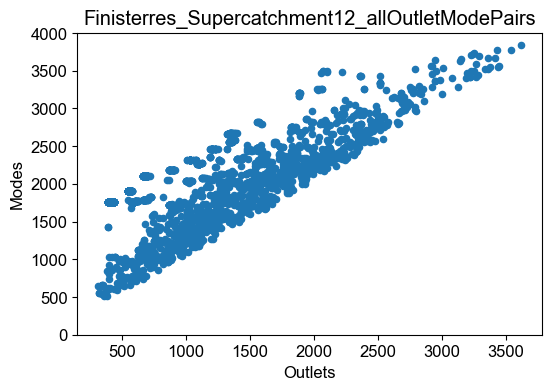

In [15]:
example_phb = list(phbs_dict.keys())[example_phb_index]
df = phbs_dict[example_phb]['raw_df']
axes = df.plot.scatter(x='Outlets',y='Modes',title=example_phb)
axes.set_ylim(0,);

## Analysis

For every supercatchment result table (now in a `pandas` dataframe), compute $\Delta{h} = h_\mathrm{mode}-h_\mathrm{outlet}$ and put into a new column in that dataframe.

In [16]:
for phb in phbs_dict:
    df = phbs_dict[phb]['raw_df']
    df['Delta_h'] = df['Modes']-df['Outlets']

Check the pdf $p(\Delta{h})$ for an example super.

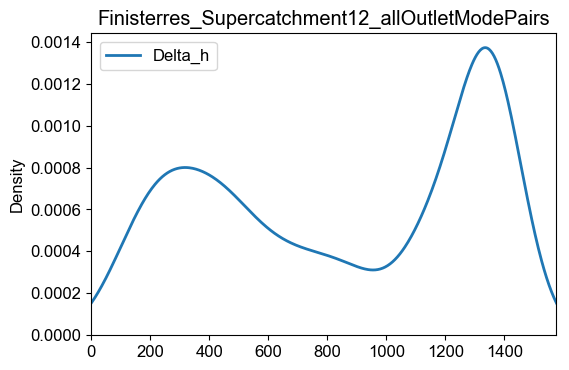

In [17]:
example_phb = list(phbs_dict.keys())[example_phb_index]

df = phbs_dict[example_phb]['raw_df']
axes = df.plot.density(x='Outlets',y='Delta_h',bw_method='silverman',
                          title=example_phb)
axes.set_xlim(0,1.1*np.max(df['Delta_h']));
axes.set_ylim(0,);

Compute a kernel-density estimated pdf for each super, and place in another dataframe for each.

In [18]:
for phb in phbs_dict:
    df = phbs_dict[phb]['raw_df']
    kde_df = compute_kde_pdf(phb,df)
    phbs_dict[phb].update({'kde_df':kde_df})

CostaRica_Supercatchment11_allOutletModePairs:  bandwidth = 66
CostaRica_Supercatchment16_allOutletModePairs:  bandwidth = 124
CostaRica_Supercatchment19_allOutletModePairs:  bandwidth = 101
CostaRica_Supercatchment1_allOutletModePairs:  bandwidth = 82
CostaRica_Supercatchment24_allOutletModePairs:  bandwidth = 67
CostaRica_Supercatchment30_allOutletModePairs:  bandwidth = 93
CostaRica_Supercatchment9_allOutletModePairs:  bandwidth = 95
Finisterres_Supercatchment12_allOutletModePairs:  bandwidth = 77
Finisterres_Supercatchment18_allOutletModePairs:  bandwidth = 103
Finisterres_Supercatchment33_allOutletModePairs:  bandwidth = 119
Finisterres_Supercatchment37_allOutletModePairs:  bandwidth = 101


For the example super, compare this kde pdf with the one generated and plotted above by `pandas`.

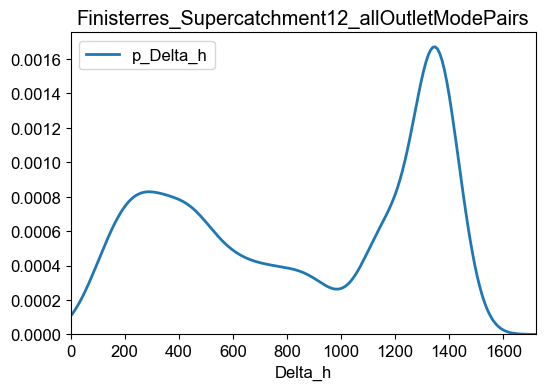

In [19]:
example_phb = list(phbs_dict.keys())[example_phb_index]
df = phbs_dict[example_phb]['kde_df']
axes = df.plot.line(x='Delta_h',y='p_Delta_h',
                          title=example_phb)
axes.set_xlim(0,np.max(df['Delta_h']));
axes.set_ylim(0,);

In [20]:
for phb in phbs_dict:
    kde_df = phbs_dict[phb]['kde_df']
    modes = find_modes(kde_df)
    phbs_dict[phb].update({'modes':modes})

In [21]:
example_phb = list(phbs_dict.keys())[example_phb_index]
example_phb
modes = phbs_dict[example_phb]['modes']
modes
print('Principal mode#1: ∆h={:.0f}m  p(∆h)={:.5f}'
      .format(modes[0,0],modes[0,1]))
print('Principal mode#2: ∆h={:.0f}m  p(∆h)={:.5f}'
      .format(modes[1,0],modes[1,1]))
if modes.shape[0]>2:
    print('Principal mode#3: ∆h={:.0f}m  p(∆h)={:.5f}'
      .format(modes[2,0],modes[2,1]))

'Finisterres_Supercatchment12_allOutletModePairs'

array([[1.34802814e+03, 1.67110105e-03],
       [2.93801005e+02, 8.28838569e-04]])

Principal mode#1: ∆h=1348m  p(∆h)=0.00167
Principal mode#2: ∆h=294m  p(∆h)=0.00083


## Plotting

## Export